## Imports

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spectral.io.envi as envi
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import load_digits
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, GridSearchCV
# from yellowbrick.model_selection import RFECV
from time import time
# from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils import shuffle

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.models import Sequential
# from keras.layers import Dense

# print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## load data 

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')
X.shape

(841005, 186)

In [ ]:
# get one percent of data only
X = X[::10, :]
y = y[::10]
X.shape

(84101, 186)

In [ ]:
# # shuffle dataset
# X, y = shuffle(X, y, random_state=42)

## Lasso regularized logistic regression

### trace coefficients and calculate accuracy and loss 

In [ ]:
# standardize dataset
X = StandardScaler().fit_transform(X)

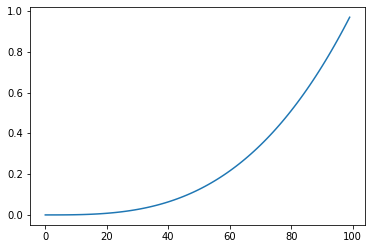

In [ ]:
# define a a list of 100 shrikage values in the range of 0 and 1
# the values are aranged a way to plot coefficient traces easier selectable
C = np.arange(0.0001, 100)
C = C * C * C
C = C / 1000000
# C.shape
plt.plot(C)

In [ ]:
%%time

# define coefficient array
co_eff_arr = np.zeros((186, 100))

# define arrayes to get mean and std_dv of training and validation accuracies
train_scores_mean_arr = np.array([])
train_scores_std_arr = np.array([])
val_scores_mean_arr = np.array([])
val_scores_std_arr = np.array([])
# define arrayes to get mean and std_dv of training and validation loss
train_loss_mean_arr = np.array([])
train_loss_std_arr = np.array([])
val_loss_mean_arr = np.array([])
val_loss_std_arr = np.array([])


for i in range(100):

  num_of_folds = 5

  kf = KFold(n_splits=5, random_state=42, shuffle=True)

  train_scores = np.array([])
  val_scores = np.array([])
  train_loss_value = np.array([])
  val_loss_value = np.array([])

  for train_index, test_index in kf.split(X):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    clf = LogisticRegression(solver='liblinear', penalty='l1', C=C[i]).fit(X_train, y_train)
                                
    train_score = clf.score(X_train, y_train)
    val_score = clf.score(X_val, y_val)
    train_loss = log_loss(y_train, clf.predict_proba(X_train))
    val_loss = log_loss(y_val, clf.predict_proba(X_val))

    train_scores = np.append(train_scores, train_score)
    val_scores = np.append(val_scores, val_score)
    train_loss_value = np.append(train_loss_value, train_loss)
    val_loss_value = np.append(val_loss_value, val_loss)

  train_scores_mean = np.mean(train_scores)
  train_scores_std = np.std(train_scores)
  val_scores_mean = np.mean(val_scores)
  val_scores_std = np.std(val_scores)

  train_loss_mean = np.mean(train_loss_value)
  train_loss_std = np.std(train_loss_value)
  val_loss_mean = np.mean(val_loss_value)
  val_loss_std = np.std(val_loss_value)

  train_scores_mean_arr = np.append(train_scores_mean_arr, train_scores_mean)
  train_scores_std_arr = np.append(train_scores_std_arr, train_scores_std)
  val_scores_mean_arr = np.append(val_scores_mean_arr, val_scores_mean)
  val_scores_std_arr = np.append(val_scores_std_arr, val_scores_std)

  train_loss_mean_arr = np.append(train_loss_mean_arr, train_loss_mean)
  train_loss_std_arr = np.append(train_loss_std_arr, train_loss_std)
  val_loss_mean_arr = np.append(val_loss_mean_arr, val_loss_mean)
  val_loss_std_arr = np.append(val_loss_std_arr, val_loss_std)


  co_eff_arr[:, i:i+1] = np.array(clf.coef_).reshape((-1, 1))

  print(i)

Store results iin drive for later use

In [ ]:
# get list of feature names from an excel file
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
feature_names = dataset.iloc[:, 2:].columns.values

df = pd.DataFrame(data=co_eff_arr, columns=C) # C is the lasso regularization param array
df.insert(loc=0, column='band_list', value=feature_names, allow_duplicates=True)

# save coefficients a csv file
df.to_csv('/content/drive/MyDrive/Thesis/results/embedded/LASSO_reg_path_LR_loss_values.csv')

# # read lasso reg path tabel from the csv file
# df = pd.read_csv('/content/drive/MyDrive/Thesis/results/embedded/LASSO_reg_path_LR.csv')
# df = df.iloc[:, 1:]
# df.head()

In [ ]:
# # get list of feature names from an excel file
# dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
# feature_names = dataset.iloc[:, 2:].columns.values

number_features = np.count_nonzero(co_eff_arr[:, :], axis=0)

# store training and validation accuracies
df2 = pd.DataFrame(data=C, columns=['C_parameter'])
df2.insert(loc=1, column='number_of_selected_features', value=number_features, allow_duplicates=True)
df2.insert(loc=2, column='train_scores_mean', value=train_scores_mean_arr, allow_duplicates=True)
df2.insert(loc=3, column='train_scores_std', value=train_scores_std_arr, allow_duplicates=True)
df2.insert(loc=4, column='val_scores_mean', value=val_scores_mean_arr, allow_duplicates=True)
df2.insert(loc=5, column='val_scores_std', value=val_scores_std_arr, allow_duplicates=True)
# save learning curve into a csv file
df2.to_csv('/content/drive/MyDrive/Thesis/results/embedded/leanrning_curve_LASSO_REG_PATH_LR_loss_values.csv')

In [ ]:
# # get list of feature names from an excel file
# dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
# feature_names = dataset.iloc[:, 2:].columns.values

# number_features = np.count_nonzero(co_eff_arr[:, :], axis=0)

# store training and validation loss
df3 = pd.DataFrame(data=C, columns=['C_parameter'])
df3.insert(loc=1, column='number_of_selected_features', value=number_features, allow_duplicates=True)
df3.insert(loc=2, column='train_loss_mean', value=train_loss_mean_arr, allow_duplicates=True)
df3.insert(loc=3, column='train_loss_std', value=val_loss_mean_arr, allow_duplicates=True)
df3.insert(loc=4, column='val_loss_mean', value=val_loss_mean_arr, allow_duplicates=True)
df3.insert(loc=5, column='val_loss_std', value=val_loss_std_arr, allow_duplicates=True)
# save learning curve into a csv file
df3.to_csv('/content/drive/MyDrive/Thesis/results/embedded/log_loss_LASSO_REG_PATH_LR_loss_values.csv')

In [ ]:
number_features = np.count_nonzero(co_eff_arr[:, :], axis=0)

### curves

In [ ]:
# read learning curve tabel from the csv file
df2 = pd.read_csv('/content/drive/MyDrive/Thesis/results/embedded/leanrning_curve_LASSO_REG_PATH_LR.csv')
df2 = df2.iloc[:, 1:]
df2.tail()

,C_parameter,number_of_selected_features,train_scores_mean,train_scores_std,val_scores_mean,val_scores_std
95,0.857378,178,0.984236,0.000190,0.983032,0.000724
96,0.884739,178,0.984162,0.000146,0.983020,0.000618
97,0.912676,178,0.984245,0.000080,0.983104,0.000666
98,0.941195,178,0.984257,0.000173,0.982925,0.000718
99,0.970302,178,0.984272,0.000140,0.983056,0.000760


In [ ]:
# read learning curve tabel from the csv file
df3 = pd.read_csv('/content/drive/MyDrive/Thesis/results/embedded/log_loss_LASSO_REG_PATH_LR_loss_values.csv')
df3 = df3.iloc[:, 1:]
df3.tail()

,C_parameter,number_of_selected_features,train_loss_mean,train_loss_std,val_loss_mean,val_loss_std
95,0.857378,178,0.048209,0.050694,0.050694,0.001480
96,0.884739,181,0.047842,0.050447,0.050447,0.001627
97,0.912676,177,0.048109,0.050622,0.050622,0.001492
98,0.941195,178,0.048060,0.050584,0.050584,0.001433
99,0.970302,179,0.048021,0.050572,0.050572,0.001515


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thesis/results/embedded/LASSO_reg_path_LR.csv')
df = df.iloc[:, 1:]
df.head()

,band_list,1e-18,1.0003000300009998e-06,8.001200060001002e-06,2.7002700090001006e-05,6.4004800120001e-05,0.00012500750015000098,0.000216010800180001,0.000343014700210001,0.000512019200240001,0.0007290243002700009,0.001000030000300001,0.0013310363003300007,0.001728043200360001,0.0021970507003900006,0.002744058800420001,0.0033750675004500007,0.0040960768004800014,0.004913086700510001,0.005832097200540001,0.00685910830057,0.0080001200006,0.00926113230063,0.010648145200660002,0.012167158700690002,0.01382417280072,0.01562518750075,0.01757620280078,0.01968321870081,0.02195223520084,0.02438925230087,0.0270002700009,0.02979128830093,0.03276830720096001,0.035937326700990015,0.03930434680102002,0.04287536750105001,0.04665638880108001,0.05065341070111002,0.05487243320114002,...,0.21600108000180002,0.22698211630183004,0.23832915320186002,0.25004819070189005,0.26214522880192004,0.27462626750195007,0.28749730680198,0.3007643467020101,0.31443338720204,0.32851042830207006,0.3430014700021001,0.35791251230213006,0.3732495552021601,0.38901859870219,0.40522564280222007,0.42187668750225,0.43897773280228003,0.4565347787023101,0.4745538252023401,0.4930408723023701,0.5120019200024001,0.5314429683024301,0.55137001720246,0.5717890667024901,0.59270611680252,0.61412716750255,0.6360582188025801,0.65850527070261,0.68147432320264,0.7049713763026701,0.7290024300027,0.7535734843027302,0.77869053920276,0.8043595947027901,0.8305866508028201,0.8573777075028501,0.8847387648028802,0.91267582270291,0.9411948812029401,0.9703019403029701
0,Band_001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.059766,-0.084126,-0.092404,-0.092541,-0.094353,-0.092484,-0.096483,-0.098562,-0.099477,-0.103259,-0.104216,-0.098869,-0.093205,-0.091379,-0.091022,-0.088508,-0.082198,-0.082482,-0.081155,-0.079771,-0.076290,-0.075923,-0.078834,-0.076194,-0.074660,-0.075760,-0.073532,...,-0.067011,-0.065014,-0.066569,-0.067302,-0.067250,-0.068619,-0.069501,-0.067192,-0.067377,-0.070641,-0.068779,-0.071288,-0.071401,-0.070031,-0.069843,-0.069791,-0.069377,-0.072455,-0.072033,-0.071556,-0.072462,-0.072659,-0.070769,-0.070783,-0.070494,-0.071567,-0.072963,-0.073004,-0.073047,-0.071022,-0.069587,-0.073635,-0.069539,-0.072223,-0.073668,-0.069886,-0.070836,-0.074156,-0.071407,-0.074013
1,Band_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.046131,-0.084101,-0.103697,-0.108849,-0.117647,-0.122123,-0.129659,-0.132290,-0.139511,-0.145894,-0.145465,-0.146255,-0.144069,-0.143422,-0.140959,-0.137474,-0.131845,-0.129029,-0.122652,-0.119541,-0.114893,-0.112826,-0.113856,-0.110980,-0.106665,-0.107751,-0.106651,...,-0.116485,-0.116657,-0.118870,-0.117418,-0.119302,-0.118723,-0.119829,-0.118737,-0.120518,-0.120338,-0.121494,-0.121094,-0.121427,-0.123549,-0.123688,-0.122588,-0.122996,-0.123083,-0.122734,-0.123939,-0.123077,-0.122867,-0.124801,-0.124057,-0.124348,-0.124019,-0.123690,-0.123424,-0.123984,-0.123993,-0.123994,-0.123871,-0.124857,-0.124160,-0.124429,-0.126866,-0.125356,-0.124284,-0.125715,-0.124275
2,Band_003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.048487,-0.071170,-0.082479,-0.087056,-0.093761,-0.102510,-0.108430,-0.110929,-0.117926,-0.121904,-0.121066,-0.121751,-0.126172,-0.128299,-0.127866,-0.128359,-0.127385,-0.129872,-0.128451,-0.130601,-0.132982,-0.131984,-0.134502,-0.138014,-0.135860,-0.138719,...,-0.183202,-0.179835,-0.181288,-0.186186,-0.181944,-0.188580,-0.183423,-0.183406,-0.186587,-0.191862,-0.185840,-0.192107,-0.193271,-0.188645,-0.189703,-0.187782,-0.190615,-0.198194,-0.198091,-0.194245,-0.200199,-0.202506,-0.195031,-0.196531,-0.195483,-0.197002,-0.206446,-0.207421,-0.208005,-0.198742,-0.198568,-0.210279,-0.202669,-0.201747,-0.212452,-0.203368,-0.203510,-0.214227,-0.203618,-0.214509
3,Band_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.006023,-0.065140,-0.095198,-0.106779,-0.113189,-0.118070,-0.124150,-0.129884,-0.135685,-0.142764,-0.145581,-0.146428,-0.147977,-0.156192,-0.158393,-0.165403,-0.168784,-0.173223,-0.176108,-0.181343,-0.187033,-0.191104,

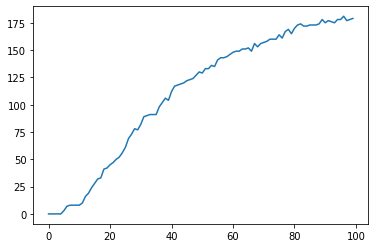

In [ ]:
plt.plot(df3.number_of_selected_features)
plt.show()

In [ ]:
lambda_values = np.float16(df.columns[1:])
str_val = lambda_values.astype(np.str)

In [ ]:
df4 = pd.DataFrame(data=df.iloc[:,1:].values, columns=str_val)
df4.tail(3)

,0.0,1e-06,8e-06,2.7e-05,6.4e-05,0.000125,0.000216,0.000343,0.000512,0.000729,0.001,0.001331,0.001728,0.002197,0.002745,0.003376,0.004097,0.004913,0.005833,0.00686,0.008,0.00926,0.01065,0.01217,0.013824,0.01563,0.01758,0.01968,0.02196,0.02438,0.027,0.02979,0.03278,0.03595,0.0393,0.04288,0.04666,0.05066,0.05487,0.05933,...,0.216,0.2269,0.2383,0.25,0.2622,0.2747,0.2876,0.3008,0.3145,0.3286,0.343,0.358,0.3733,0.389,0.4053,0.4219,0.439,0.4565,0.4746,0.493,0.512,0.5312,0.5513,0.572,0.593,0.6143,0.636,0.6587,0.6816,0.705,0.729,0.7534,0.779,0.804,0.8306,0.8574,0.885,0.9126,0.9414,0.97
183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.010478,0.097906,0.170992,0.228219,0.283424,0.329718,0.370392,0.409721,0.442460,0.473550,0.507088,0.535845,0.564822,0.592436,0.615596,0.640880,0.662353,0.684769,0.703410,...,0.936055,0.945112,0.948823,0.952225,0.959136,0.963357,0.972583,0.977166,0.977878,0.981063,0.986245,0.990718,0.994475,0.999825,1.000184,1.006574,1.011670,1.014503,1.017604,1.019962,1.024256,1.028528,1.027851,1.032500,1.033370,1.034994,1.045034,1.047798,1.049629,1.047262,1.046776,1.056587,1.052131,1.054330,1.064918,1.058080,1.060083,1.072464,1.064177,1.075285
184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104092,0.213194,0.318663,0.392342,0.454637,0.493314,0.537553,0.574317,0.609758,0.631322,0.665755,0.687617,0.707456,0.719286,0.738504,0.768014,0.783983,0.791770,0.816642,0.831504,0.845997,...,1.039063,1.039064,1.044012,1.059865,1.057776,1.074714,1.069031,1.078311,1.080927,1.098824,1.091943,1.109152,1.114492,1.109407,1.112590,1.122548,1.122747,1.145375,1.146152,1.136578,1.154777,1.161687,1.150978,1.159060,1.155295,1.161997,1.181311,1.184098,1.187729,1.170265,1.174364,1.196280,1.182421,1.184868,1.204152,1.189287,1.191712,1.211583,1.194712,1.216856
185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.066992,0.169241,0.264803,0.329222,0.384171,0.429943,0.475749,0.508007,0.550171,0.578762,0.609410,0.638053,0.667786,0.693507,0.713913,0.737355,0.765001,0.783864,0.797998,0.815757,...,1.063025,1.055265,1.063214,1.089259,1.075351,1.106952,1.087410,1.096760,1.103880,1.136264,1.113929,1.146803,1.153760,1.129967,1.135809,1.143042,1.145028,1.184271,1.186668,1.159365,1.194773,1.205367,1.175206,1.175539,1.175991,1.183835,1.226538,1.230440,1.234662,1.194054,1.197632,1.244616,1.207081,1.208235,1.254051,1.217126,1.217285,1.264193,1.220135,1.271556


[]

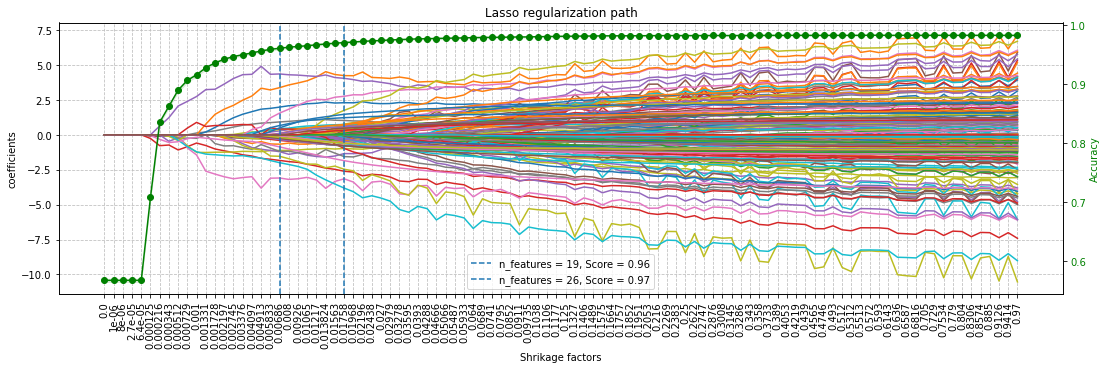

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 5))

# rotate x-ticks
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)

ax1.plot(np.transpose(df4.iloc[:, :]), color='gray')

# ax1.plot(0, 'o-', color='green', label='Accuracy') # just to add legend for second axis

# ax1.axvline(x=19	, ls='--', label='n_features = {}, Score = {}'.format(19, round(0.961035, 2)))
# ax1.axvline(x=26	, ls='--', label='n_features = {}, Score = {}'.format(26, round(0.970702, 2)))

ax1.set_xlabel('Shrikage factors')
ax1.set_ylabel('coefficients')
ax1.set_title('Lasso regularization path')
ax1.grid(b=True, which='major', color='silver', linestyle='--')
ax1.legend(loc="lower center")

steps = np.arange(100)
ax2 = ax1.twinx()
ax2.fill_between(steps, df2.val_scores_mean.values - df2.val_scores_std.values,
                 df2.val_scores_mean.values + df2.val_scores_std.values, alpha=0.1, color="g")
ax2.plot(steps, df2.val_scores_mean.values, 'o-', color='green')

ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# ax1.axvline

ax1.plot()

[]

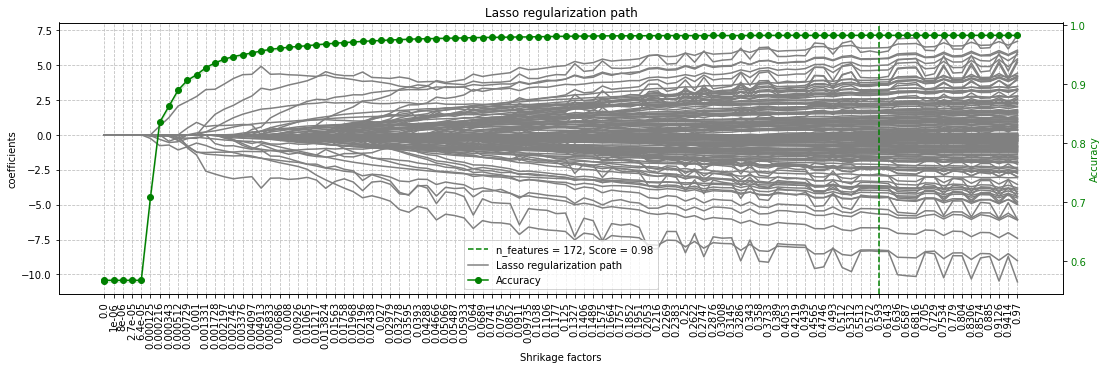

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 5))

# rotate x-ticks
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)

ax1.plot(np.transpose(df4.iloc[:, :]), color='gray')

# ax1.plot(0, 'o-', color='green', label='Accuracy') # just to add legend for second axis

# ax1.axvline(x=19	, ls='--', label='n_features = {}, Score = {}'.format(19, round(0.961035, 2)))
# ax1.axvline(x=26	, ls='--', label='n_features = {}, Score = {}'.format(26, round(0.970702, 2)))
ax1.axvline(x=df2.val_scores_mean.values.argmax() + 1, color="green", ls='--', label='n_features = {}, Score = {}'.format(df2.number_of_selected_features[df2.val_scores_mean.values.argmax()+1], round(df2.val_scores_mean.values.max(), 2)))

# helper for legends
ax1.plot(0, 0, color='gray', label='Lasso regularization path')
ax1.plot(0, -10.5, 'o-', color='green', label='Accuracy')

ax1.set_xlabel('Shrikage factors')
ax1.set_ylabel('coefficients')
ax1.set_title('Lasso regularization path')
ax1.grid(b=True, which='major', color='silver', linestyle='--')
ax1.legend(loc="lower center")

steps = np.arange(100)
ax2 = ax1.twinx()
ax2.fill_between(steps, df2.val_scores_mean.values - df2.val_scores_std.values,
                 df2.val_scores_mean.values + df2.val_scores_std.values, alpha=0.1, color="g")
ax2.plot(steps, df2.val_scores_mean.values, 'o-', color='green')

ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# ax1.axvline

ax1.plot()

[]

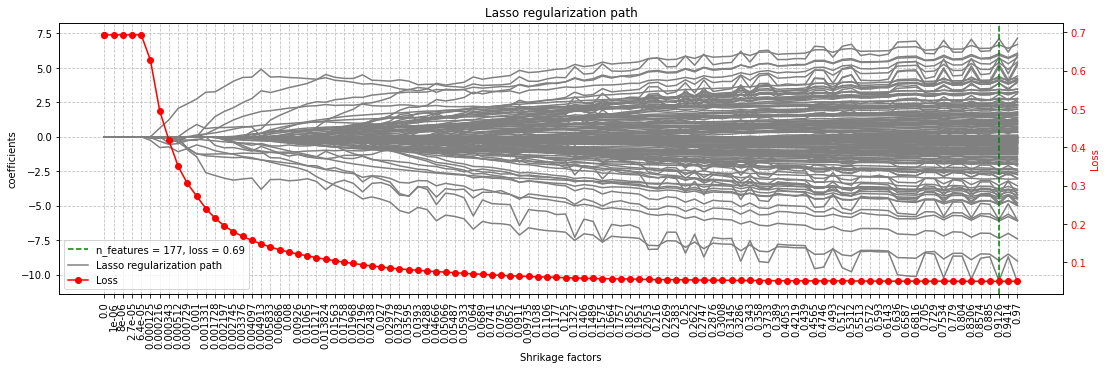

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 5))

# rotate x-ticks
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)

ax1.plot(np.transpose(df4.iloc[:, :]), color='gray')

# ax1.plot(0, 'o-', color='green', label='Accuracy') # just to add legend for second axis

# ax1.axvline(x=19	, ls='--', label='n_features = {}, Score = {}'.format(19, round(0.961035, 2)))
# ax1.axvline(x=26	, ls='--', label='n_features = {}, Score = {}'.format(26, round(0.970702, 2)))
ax1.axvline(x=df3.val_loss_mean.values.argmin() + 1, color="green", ls='--', label='n_features = {}, loss = {}'.format(df3.number_of_selected_features[df3.val_loss_mean.values.argmin()+1], round(df3.val_loss_mean.values.max(), 2)))

# helper for legends
ax1.plot(0, 0, color='gray', label='Lasso regularization path')
ax1.plot(0, 7.4, 'o-', color='red', label='Loss')

ax1.set_xlabel('Shrikage factors')
ax1.set_ylabel('coefficients')
ax1.set_title('Lasso regularization path')
ax1.grid(b=True, which='major', color='silver', linestyle='--')
ax1.legend(loc="lower left")

steps = np.arange(100)
ax2 = ax1.twinx()
ax2.fill_between(steps, df3.val_loss_mean.values - df3.val_loss_std.values,
                 df3.val_loss_mean.values + df3.val_loss_std.values, alpha=0.1, color="g")
ax2.plot(steps, df3.val_loss_mean.values, 'o-', color='red')

ax2.set_ylabel('Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')


# ax1.axvline

ax1.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[]

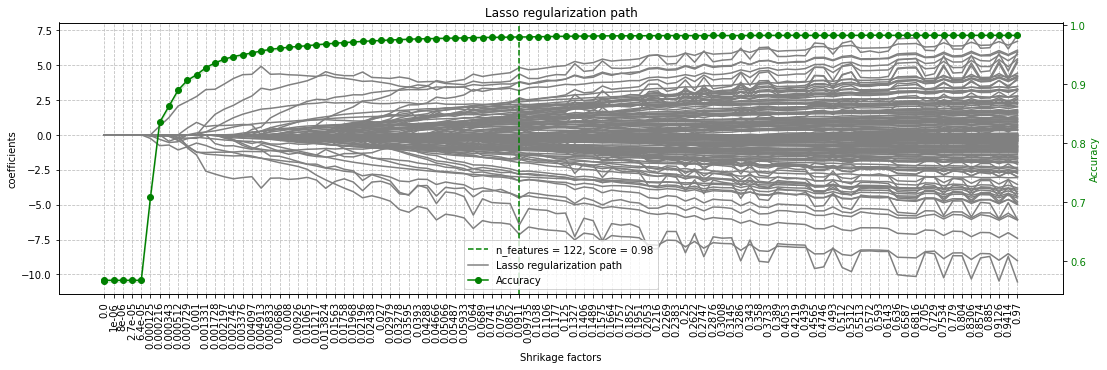

In [ ]:
stopping_critera = 0.002

fig, ax1 = plt.subplots(figsize=(18, 5))

# rotate x-ticks
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)

ax1.plot(np.transpose(df4.iloc[:, :]), color='gray')

# ax1.plot(0, 'o-', color='green', label='Accuracy') # just to add legend for second axis

# ax1.axvline(x=19	, ls='--', label='n_features = {}, Score = {}'.format(19, round(0.961035, 2)))
# ax1.axvline(x=26	, ls='--', label='n_features = {}, Score = {}'.format(26, round(0.970702, 2)))
# ax1.axvline(x=df2.val_scores_mean.values.argmax() + 1, color="green", ls='--', label='n_features = {}, Score = {}'.format(df2.number_of_selected_features[df2.val_scores_mean.values.argmax()+1], round(df2.val_scores_mean.values.max(), 2)))

# selected features based on new stopping criteria
LR_filtered_features_index = np.array([])
for i in range(100):
  if np.subtract(df2.val_scores_mean[i+9:i+10].values, df2.val_scores_mean[i:i+1].values) < stopping_critera:
    LR_filtered_features_index = np.append(LR_filtered_features_index, i)
LR_number_ind = LR_filtered_features_index.min() + 1
LR_number_features = df2.number_of_selected_features[LR_number_ind]

plt.axvline(x=int(LR_number_ind), ls='--', color="green", label='n_features = {}, Score = {}'.format(int(LR_number_features), str(round(df2.val_scores_mean[int(LR_number_ind)], 2))))


# helper for legends
ax1.plot(0, 0, color='gray', label='Lasso regularization path')
ax1.plot(0, -10.5, 'o-', color='green', label='Accuracy')

ax1.set_xlabel('Shrikage factors')
ax1.set_ylabel('coefficients')
ax1.set_title('Lasso regularization path')
ax1.grid(b=True, which='major', color='silver', linestyle='--')
ax1.legend(loc="lower center")

steps = np.arange(100)
ax2 = ax1.twinx()
ax2.fill_between(steps, df2.val_scores_mean.values - df2.val_scores_std.values,
                 df2.val_scores_mean.values + df2.val_scores_std.values, alpha=0.1, color="g")
ax2.plot(steps, df2.val_scores_mean.values, 'o-', color='green')

ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# ax1.axvline

ax1.plot()

[]

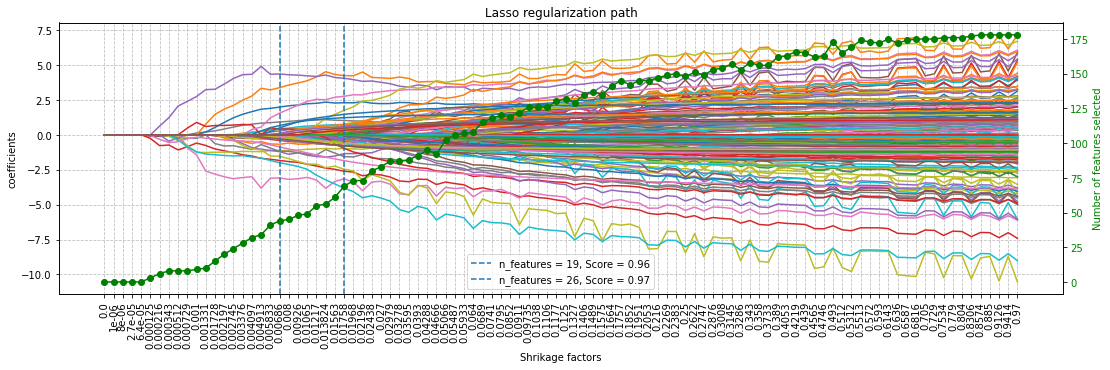

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 5))

# rotate x-ticks
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)

ax1.plot(np.transpose(df4.iloc[:, :]))

# ax1.plot(0, 'o-', color='green', label='Accuracy') # just to add legend for second axis

ax1.axvline(x=19	, ls='--', label='n_features = {}, Score = {}'.format(19, round(0.961035, 2)))
ax1.axvline(x=26	, ls='--', label='n_features = {}, Score = {}'.format(26, round(0.970702, 2)))

ax1.set_xlabel('Shrikage factors')
ax1.set_ylabel('coefficients')
ax1.set_title('Lasso regularization path')
ax1.grid(b=True, which='major', color='silver', linestyle='--')
ax1.legend(loc="lower center")

steps = np.arange(100)
ax2 = ax1.twinx()
# ax2.fill_between(steps, df2.val_scores_mean.values - df2.val_scores_std.values,
#                  df2.val_scores_mean.values + df2.val_scores_std.values, alpha=0.1, color="g")
ax2.plot(steps, df2.number_of_selected_features.values, 'o-', color='green')

ax2.set_ylabel('Number of features selected', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# ax1.axvline

ax1.plot()

[]

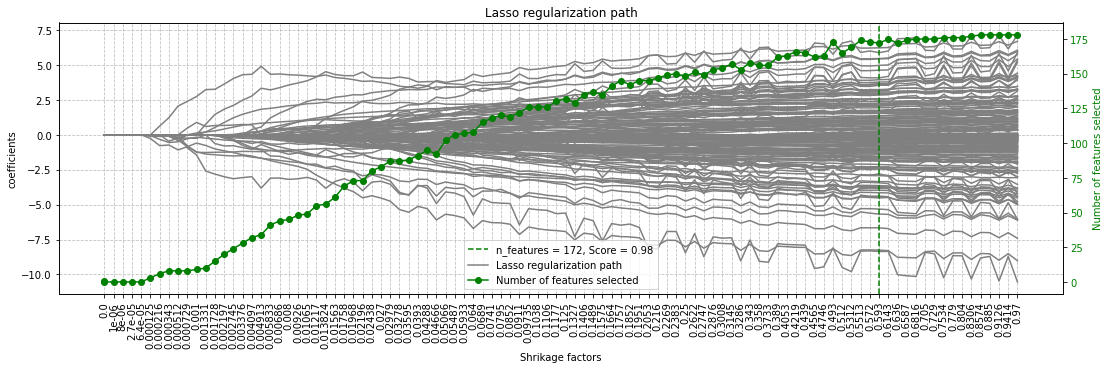

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 5))

# rotate x-ticks
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)

ax1.plot(np.transpose(df4.iloc[:, :]), color='gray')

# ax1.plot(0, 'o-', color='green', label='Accuracy') # just to add legend for second axis

# ax1.axvline(x=19	, ls='--', label='n_features = {}, Score = {}'.format(19, round(0.961035, 2)))
# ax1.axvline(x=26	, ls='--', label='n_features = {}, Score = {}'.format(26, round(0.970702, 2)))
ax1.axvline(x=df2.val_scores_mean.values.argmax() + 1, color="green", ls='--', label='n_features = {}, Score = {}'.format(df2.number_of_selected_features[df2.val_scores_mean.values.argmax()+1], round(df2.val_scores_mean.values.max(), 2)))

# helper for legends
ax1.plot(0, 0, color='gray', label='Lasso regularization path')
ax1.plot(0, -10.5, 'o-', color='green', label='Number of features selected')

ax1.set_xlabel('Shrikage factors')
ax1.set_ylabel('coefficients')
ax1.set_title('Lasso regularization path')
ax1.grid(b=True, which='major', color='silver', linestyle='--')
ax1.legend(loc="lower center")

steps = np.arange(100)
ax2 = ax1.twinx()
# ax2.fill_between(steps, df2.val_scores_mean.values - df2.val_scores_std.values,
#                  df2.val_scores_mean.values + df2.val_scores_std.values, alpha=0.1, color="g")
ax2.plot(steps, df2.number_of_selected_features.values, 'o-', color='green')

ax2.set_ylabel('Number of features selected', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# ax1.axvline

ax1.plot()

[]

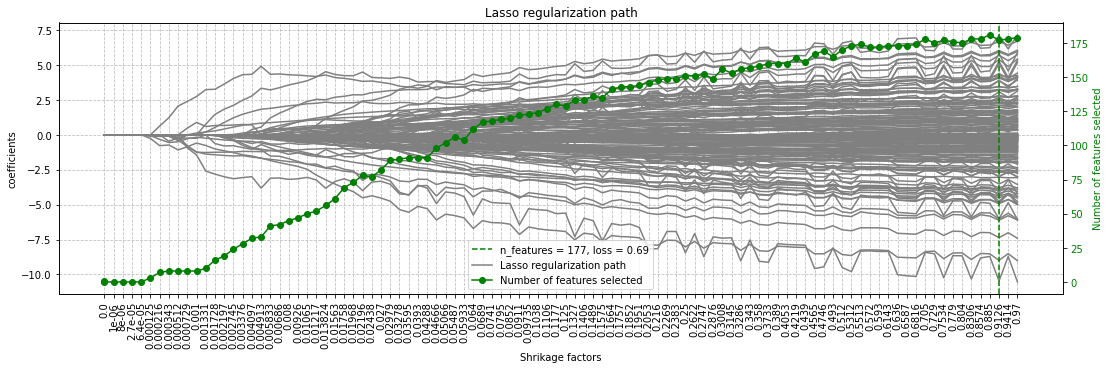

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 5))

# rotate x-ticks
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)

ax1.plot(np.transpose(df4.iloc[:, :]), color='gray')

# ax1.plot(0, 'o-', color='green', label='Accuracy') # just to add legend for second axis

# ax1.axvline(x=19	, ls='--', label='n_features = {}, Score = {}'.format(19, round(0.961035, 2)))
# ax1.axvline(x=26	, ls='--', label='n_features = {}, Score = {}'.format(26, round(0.970702, 2)))
ax1.axvline(x=df3.val_loss_mean.values.argmin() + 1, color="green", ls='--', label='n_features = {}, loss = {}'.format(df3.number_of_selected_features[df3.val_loss_mean.values.argmin()+1], round(df3.val_loss_mean.values.max(), 2)))

# helper for legends
ax1.plot(0, 0, color='gray', label='Lasso regularization path')
ax1.plot(0, -10.5, 'o-', color='green', label='Number of features selected')

ax1.set_xlabel('Shrikage factors')
ax1.set_ylabel('coefficients')
ax1.set_title('Lasso regularization path')
ax1.grid(b=True, which='major', color='silver', linestyle='--')
ax1.legend(loc="lower center")

steps = np.arange(100)
ax2 = ax1.twinx()
# ax2.fill_between(steps, df2.val_scores_mean.values - df2.val_scores_std.values,
#                  df2.val_scores_mean.values + df2.val_scores_std.values, alpha=0.1, color="g")
ax2.plot(steps, df3.number_of_selected_features.values, 'o-', color='green')

ax2.set_ylabel('Number of features selected', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# ax1.axvline

ax1.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[]

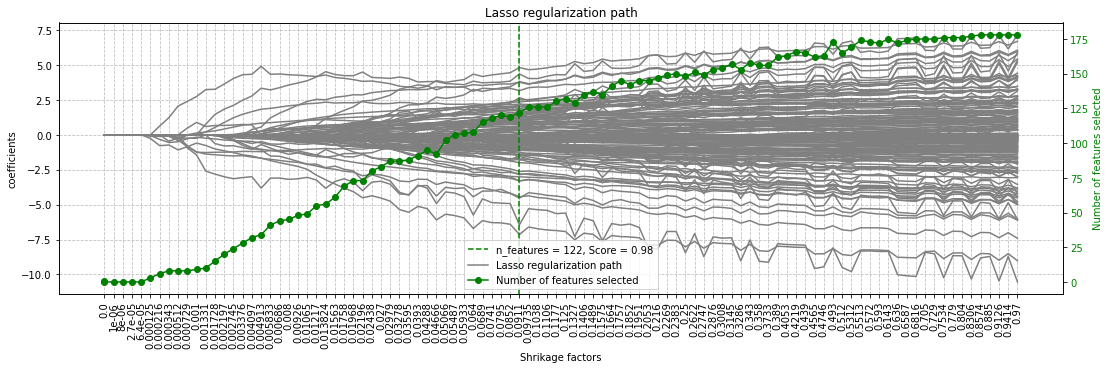

In [ ]:
stopping_critera = 0.002

fig, ax1 = plt.subplots(figsize=(18, 5))

# rotate x-ticks
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)

ax1.plot(np.transpose(df4.iloc[:, :]), color='gray')

# ax1.plot(0, 'o-', color='green', label='Accuracy') # just to add legend for second axis

# ax1.axvline(x=19	, ls='--', label='n_features = {}, Score = {}'.format(19, round(0.961035, 2)))
# ax1.axvline(x=26	, ls='--', label='n_features = {}, Score = {}'.format(26, round(0.970702, 2)))
# ax1.axvline(x=df2.val_scores_mean.values.argmax() + 1, color="green", ls='--', label='n_features = {}, Score = {}'.format(df2.number_of_selected_features[df2.val_scores_mean.values.argmax()+1], round(df2.val_scores_mean.values.max(), 2)))

# selected features based on new stopping criteria
LR_filtered_features_index = np.array([])
for i in range(100):
  if np.subtract(df2.val_scores_mean[i+9:i+10].values, df2.val_scores_mean[i:i+1].values) < stopping_critera:
    LR_filtered_features_index = np.append(LR_filtered_features_index, i)
LR_number_ind = LR_filtered_features_index.min() + 1
LR_number_features = df2.number_of_selected_features[LR_number_ind]

plt.axvline(x=int(LR_number_ind), ls='--', color="green", label='n_features = {}, Score = {}'.format(int(LR_number_features), str(round(df2.val_scores_mean[int(LR_number_ind)], 2))))


# helper for legends
ax1.plot(0, 0, color='gray', label='Lasso regularization path')
ax1.plot(0, -10.5, 'o-', color='green', label='Number of features selected')

ax1.set_xlabel('Shrikage factors')
ax1.set_ylabel('coefficients')
ax1.set_title('Lasso regularization path')
ax1.grid(b=True, which='major', color='silver', linestyle='--')
ax1.legend(loc="lower center")

steps = np.arange(100)
ax2 = ax1.twinx()
# ax2.fill_between(steps, df2.val_scores_mean.values - df2.val_scores_std.values,
#                  df2.val_scores_mean.values + df2.val_scores_std.values, alpha=0.1, color="g")
ax2.plot(steps, df2.number_of_selected_features.values, 'o-', color='green')

ax2.set_ylabel('Number of features selected', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# ax1.axvline

ax1.plot()

In [ ]:
LR_filtered_features_index = np.array([])
for i in range(100):
  if np.subtract(df2.val_scores_mean[i+9:i+10].values, df2.val_scores_mean[i:i+1].values) < stopping_critera:
    LR_filtered_features_index = np.append(LR_filtered_features_index, i)
LR_number_ind = LR_filtered_features_index.min() + 1

a = df2.val_scores_mean.values.argmax()
b = int(LR_number_ind)
h_df = pd.DataFrame(data=df.iloc[:,a:a+1].values, columns=['Highest Performance Stopping Criteria'])
h_df.insert(loc=1, column='Newly defined Stopping Criteria', value=df.iloc[:,b:b+1].values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

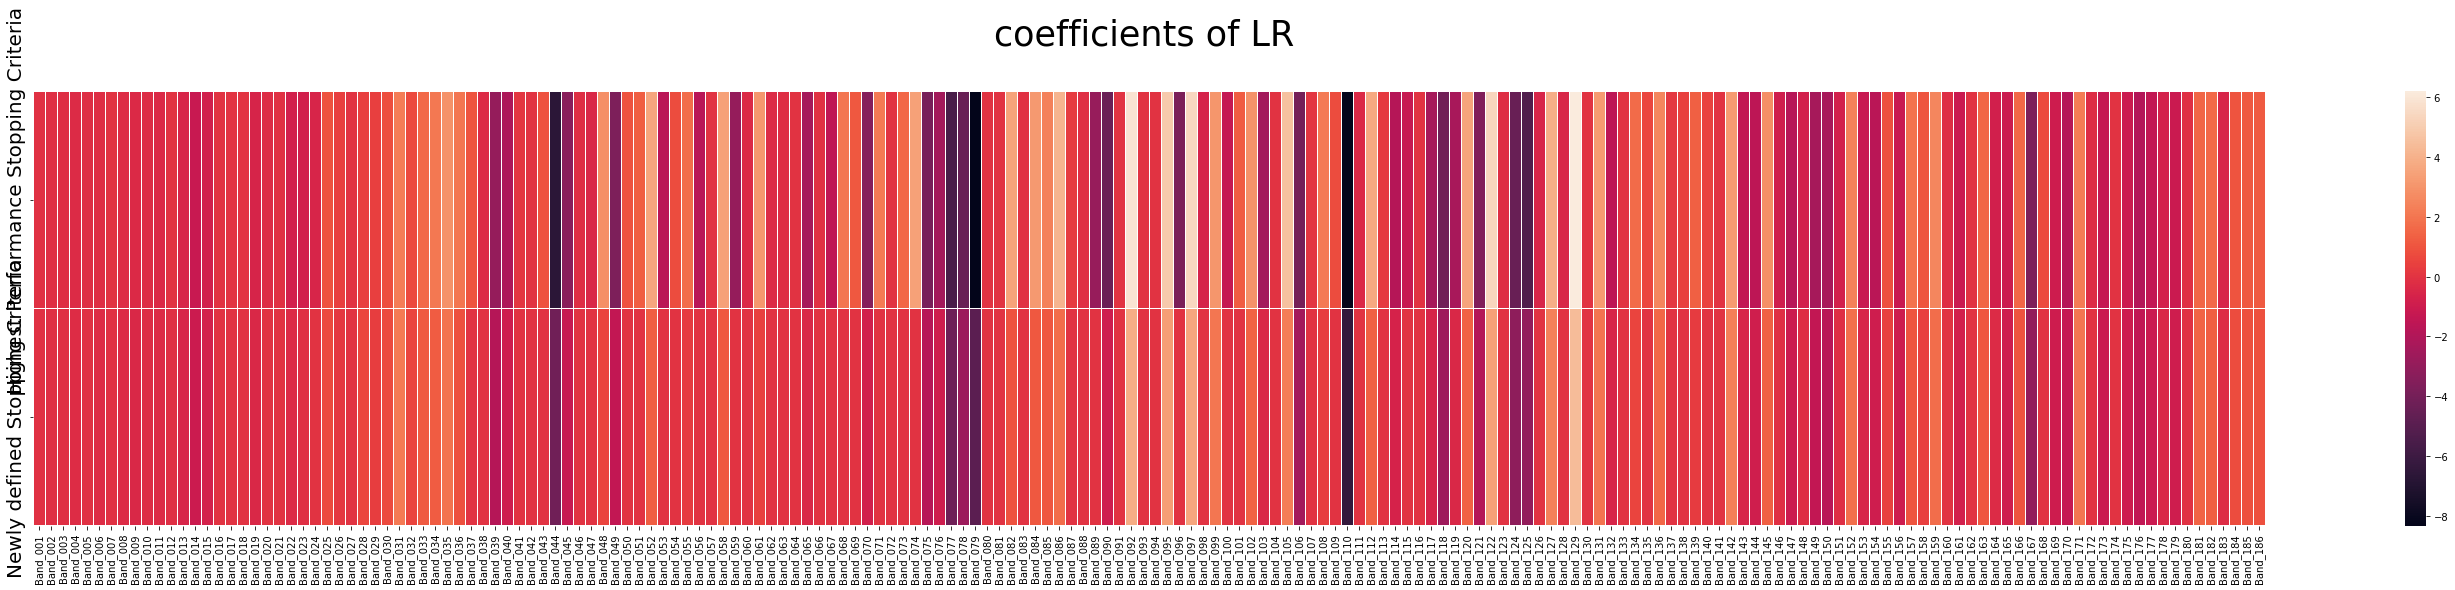

In [ ]:
fig, ax = plt.subplots(figsize=(50,8))
# ax.set_title('')
sns_plot = sns.heatmap(data=np.transpose(h_df.iloc[:,:].values), annot=False, linewidths=0.01,
                       xticklabels=df.band_list.values[:], yticklabels=h_df.columns.values[:], ax=ax)
plt.title('coefficients of LR \n', fontsize=35)
plt.yticks(fontsize=20)

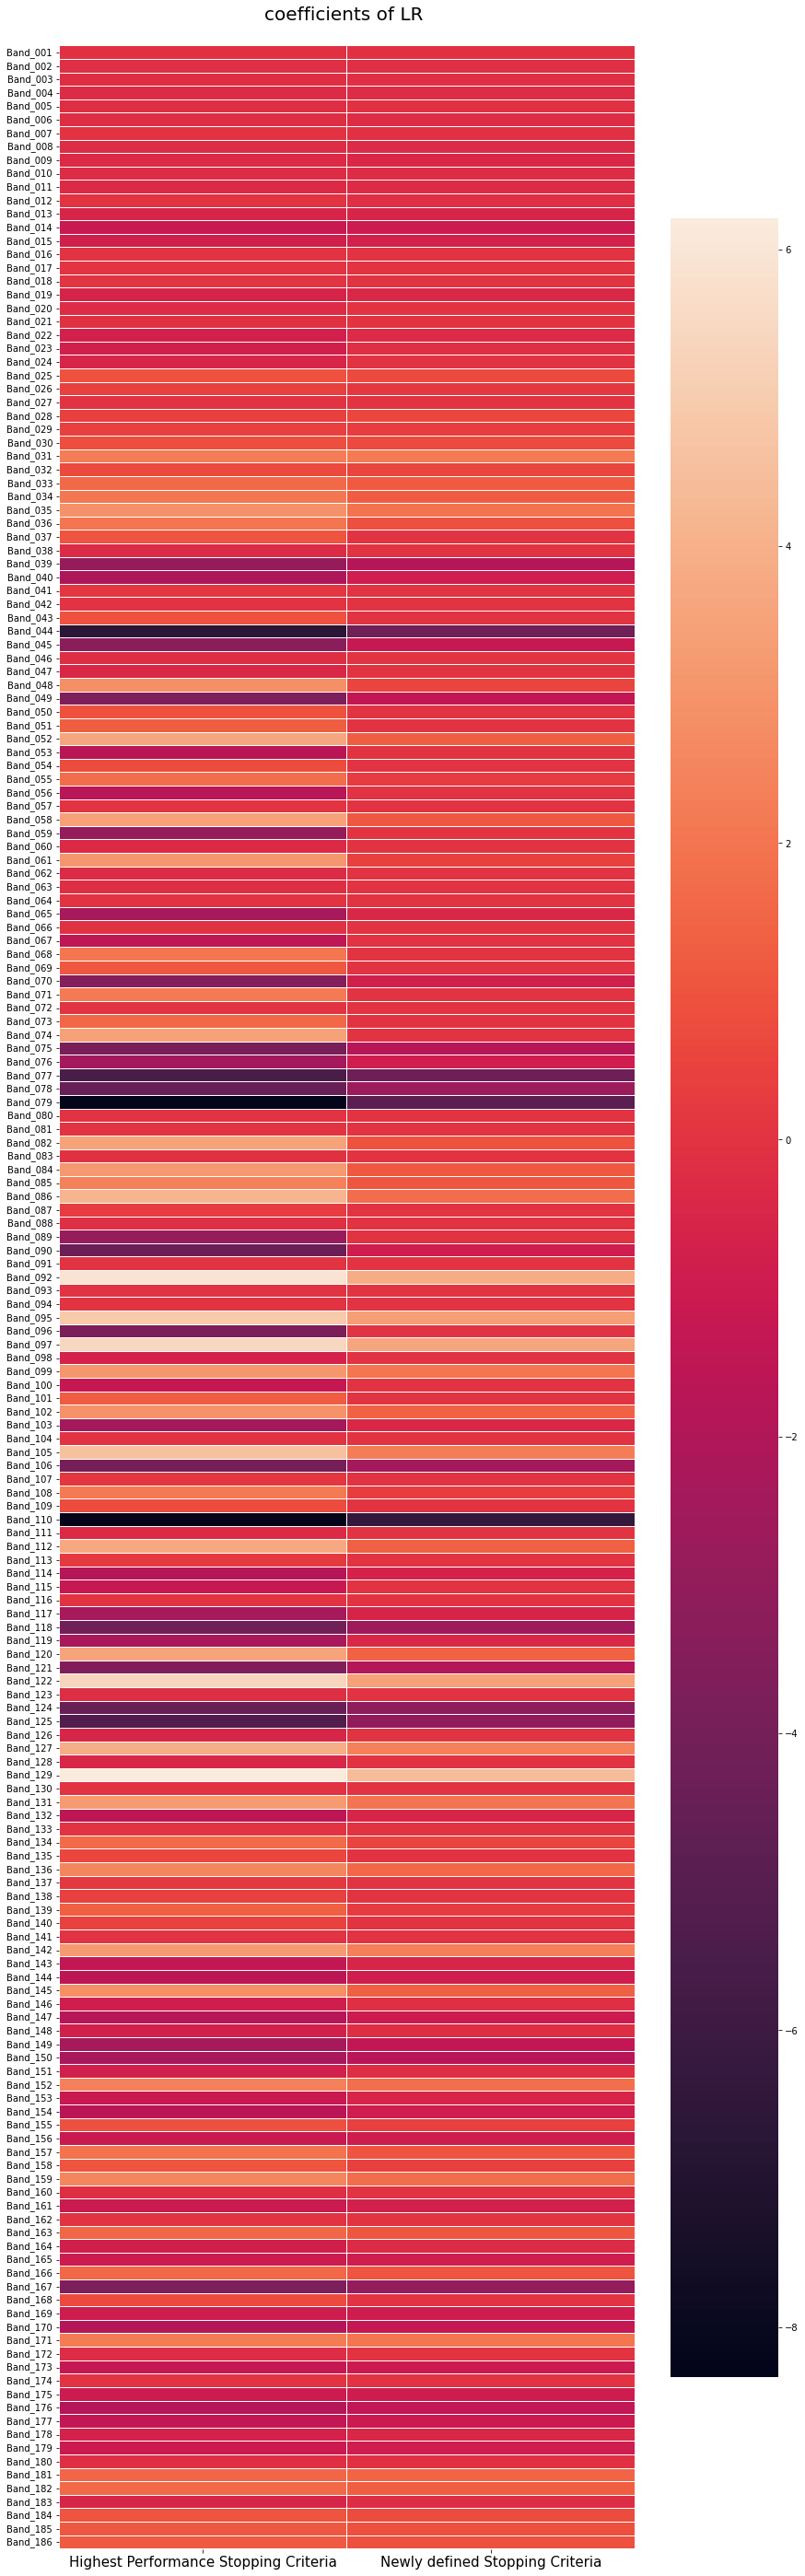

In [ ]:
fig, ax = plt.subplots(figsize=(14,50))
# ax.set_title('')
sns_plot = sns.heatmap(data=h_df.iloc[:,:].values, annot=False, linewidths=0.01, 
                       yticklabels=df.band_list.values[:], xticklabels=h_df.columns.values[:], ax=ax)

plt.title('coefficients of LR \n', fontsize=20)
plt.xticks(fontsize=15, rotation=0)
# plt.yticks(fontsize=20)
plt.show()

No handles with labels found to put in legend.


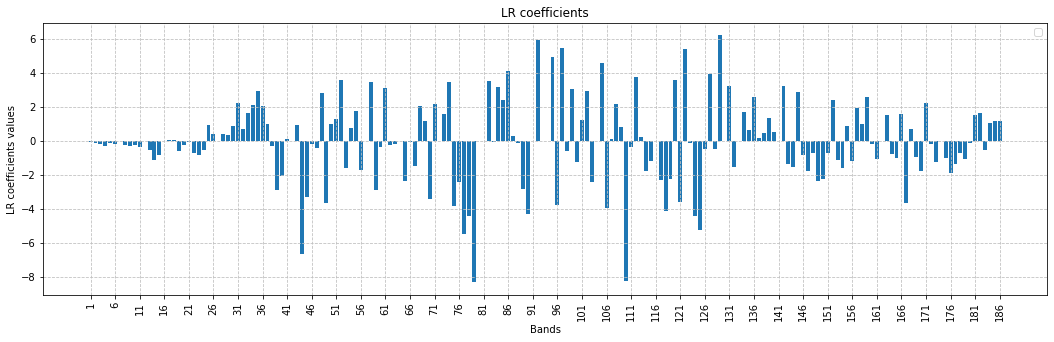

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, h_df.iloc[:,0:1].values.flatten())
plt.ylabel('LR coefficients values')
plt.xlabel('Bands')
plt.title('LR coefficients')
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

No handles with labels found to put in legend.


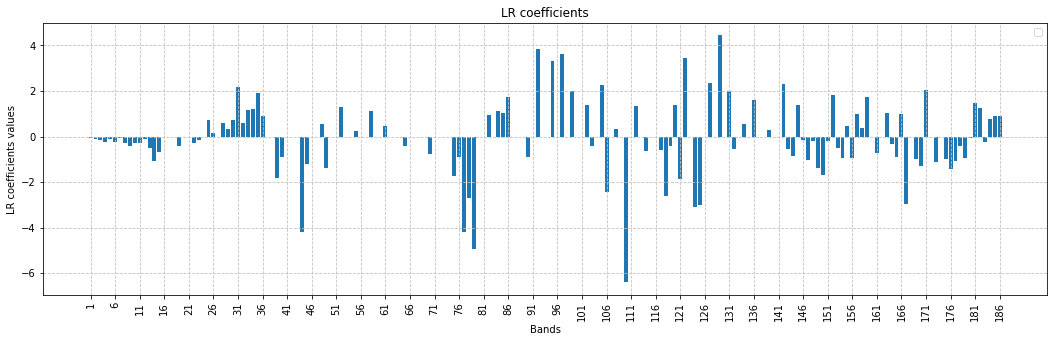

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, h_df.iloc[:,1:2].values.flatten())
plt.ylabel('LR coefficients values')
plt.xlabel('Bands')
plt.title('LR coefficients')
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
# restart runtime and clear ram
import os, signal
os.kill(os.getpid(), signal.SIGKILL)